### Code in this notebook creates these descriptive statistics: ###
1. Data Date Range: 
    <br />Start time: 2016-05-05 09:40:26
    <br />End time: 2018-01-17 01:59:42
2. The unique number of users;   
3. Number of users who've viewed a trailer;
4. Number of users who've viewed a recommended trailer; 
5. The median of # of user logins; 
6. Percentages of a trailer people tend to watch, with visualization;
7. Number of times a trailer (among all trailers played, and among recommended ones) is liked
8. Summary statistics of some interesting actions: PlayedFromRecommendation; TrailerEnded; MovieDetailsModalOpened; WishlistedMovie; etc. 


### Import

In [41]:
import pandas as pd
import numpy as np

In [42]:
%matplotlib inline
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# 2.23.2018 Update: removed grouplens researchers

# Connect to the database
import pymysql.cursors
import json
import re

# We will use these lists to generate a table later. 

# Connect to the database
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")

try:
    with connection.cursor() as cursor:
        # This query select rows from log_trailer_actions where the action is either TrailerModalLaunched or Recommendations Refreshed
        # These two actions indicate that a recommendation list is generated. 
        
        sql = """
        SELECT expt_trailer.userId, expt_trailer.loginId, expt_trailer.recommenderId, expt_trailer.tstamp
        FROM user_data
        RIGHT JOIN expt_trailer
        ON expt_trailer.userId = user_data.userId
        WHERE expt_trailer.tstamp < '2018-01-17 01:59:42' AND user_data.excludeFromExperiments='N'
        """
        cursor.execute(sql)
        result = cursor.fetchall()
        # Iterate each row in the query result
        
            
finally: 
    connection.close()


ModuleNotFoundError: No module named 'pymysql'

In [44]:
trailers = pd.DataFrame(list(result), columns=['userId','loginId','recommenderId','tstamp'])

NameError: name 'result' is not defined

In [7]:
trailers.count()

userId           482958
loginId          482958
recommenderId    482958
tstamp           482958
dtype: int64

In [9]:
# The start time of this experiment:
trailers.sort_values('tstamp').head()
# 2016-05-05 09:40:26

,userId,loginId,recommenderId,tstamp
134109,252814,GwbbzG0,PredictedRating,2016-05-05 09:58:09
134112,252814,k36DOjv,ShuffledTopPicks,2016-05-05 10:52:54
117476,244578,71GaXi1,FilmReleaseDate,2016-05-05 13:31:03
117565,244578,ysUtPjR,FilmReleaseDate,2016-05-05 13:33:33
117533,244578,p5g7EnY,ShuffledTopPicks,2016-05-05 13:50:09


In [10]:
# The end time of this experiment:
trailers.sort_values('tstamp').tail()
# 2018-01-17 01:59:42

,userId,loginId,recommenderId,tstamp
298295,292342,gxttFfa,PredictedRating,2018-01-17 01:44:23
372964,302307,eA3X8M5,ShuffledTopPicks,2018-01-17 01:48:15
86200,209900,zXLlgxp,ShuffledTopPicks,2018-01-17 01:48:38
482352,317343,ynqYKeJ,PredictedRating,2018-01-17 01:51:41
179342,265812,Hat0xrC,FilmReleaseDate,2018-01-17 01:56:24


### Finding the total number of unique users 


In [5]:
# Finding the total number of unique users assigned a condition
len(trailers['userId'].unique())

39399

In [6]:
# Finding the total number of unique user logins
len(trailers['loginId'].unique())

482958

### Number of trailer views

In [45]:
total_rec_alg = pd.read_csv('../Clean_Data/total_rec_refresh_aggregate.csv', sep=',')
total_rec_alg['count_total_played'].sum()

166959

In [48]:
total_rec_alg.head()

,Unnamed: 0,userId,loginId,Algorithm,count_total_played,count_rec_played,count_refresh
0,0,1892,Nm0bajY,TagSimilarity,1,0.0,0.0
1,1,12337,OnHpLST,PredictedRating,1,0.0,0.0
2,2,16783,2bqCVrC,TagSimilarity,19,0.0,0.0
3,3,22005,M1nww5f,ShuffledTopPicks,1,0.0,0.0
4,4,26229,t7hZ2Ty,PredictedRating,1,0.0,0.0


### Number of recommended trailer views

In [47]:
total_rec_alg['count_rec_played'].sum()


9142.0

### Finding the median number of times a user has logged in  ###

In [15]:
# Finding the median number of times a user has logged in 
"""
1. For each user, find the count of this userId in the dataset
2. Sort by # of times
3. Find median
"""
trailers.groupby('userId').count()['loginId'].median()


2.0

### How many percentages of a trailer people tend to watch? ### 

In [25]:
# Data ends on 2018-01-17
watch = pd.read_csv('../Clean_Data/log_trailer_watch.csv')
watch_small = watch[watch['tstamp']<"2018-01-17 01:59:42"]

mlusers = [32451,49002,49253,50540,51234,51714,65817,66644,68903,70023,70026,92721,92723,95195,96279,96483,96691,97397,104218,113699,114092,114844,122798,124450,124790,125283,125431,127628,127979,129299,130353,132131,132145,132637,132726,132728,132871,133047,134070,134088,134143,134235,134342,134349,134372,134373,134393,134484,134496,134498,134504,134533,135260,135670,136346,136505,136995,137096,137331,137372,138083,138089,138090,138108,141799,142115,143473,149815,151709,151982,166008,173637,176970,183038,183567,197881,202657,207221,221192,221515,225510,233659,233985,237287,237332,238576,238876,240312,242238,242683,243010,243445,245696,246018,246058,246587,246828,248583,251610,251922,252238,252534,253066,253866,253869,257628,257629,257756,258553,258554,258555,258556,258557,258558,258559,258560,258561,258562,258563,258564,258565,259056,260701,264178,266542,268253,269945,286014,287206,292397,301040,304542,313322,316070,317416,318334]

watch_noml = watch_small[~watch_small.userId.isin(mlusers)].copy()
watch_noml

,userId,loginId,movieId,youtubeTrailerId,percentWatched,positionInList,tstamp
49,285205,amb977W,66156,qBBiLLjK5XY,15,0,2016-05-05 16:10:42
50,285205,amb977W,66156,qBBiLLjK5XY,30,0,2016-05-05 16:10:58
51,285205,amb977W,66156,qBBiLLjK5XY,45,0,2016-05-05 16:11:11
52,271845,28lSfpJ,60684,PVgUZ2NSzBo,15,0,2016-05-05 16:55:19
53,271845,28lSfpJ,60684,PVgUZ2NSzBo,30,0,2016-05-05 16:55:40
54,271845,28lSfpJ,60684,PVgUZ2NSzBo,45,0,2016-05-05 16:56:00
55,271845,28lSfpJ,4448,-h5UgLvoaok,15,0,2016-05-05 17:01:01
56,271845,28lSfpJ,4448,-h5UgLvoaok,30,0,2016-05-05 17:01:23
57,285565,ElIYhrB,152081,jWM0ct-OLsM,15,0,2016-05-05 17:02:42
58,285565,ElIYhrB,152081,jWM0ct-OLsM,30,0,2016-05-05 17:03:07


In [26]:
# Bug here!
watch_noml.sort_values('percentWatched',ascending=False, inplace=True)

In [27]:
watch_noml.sort_values(by=['loginId','movieId'],inplace=True)

In [28]:
watch_noml = watch_noml[watch_noml['percentWatched']<=100].copy()

In [29]:
watch_noml

,userId,loginId,movieId,youtubeTrailerId,percentWatched,positionInList,tstamp
116436,276159,008C57f,118985,2xD9uTlh5hI,90,0,2016-09-12 13:55:20
116435,276159,008C57f,118985,2xD9uTlh5hI,75,0,2016-09-12 13:54:57
116434,276159,008C57f,118985,2xD9uTlh5hI,60,0,2016-09-12 13:54:35
116433,276159,008C57f,118985,2xD9uTlh5hI,45,0,2016-09-12 13:54:12
116432,276159,008C57f,118985,2xD9uTlh5hI,30,0,2016-09-12 13:53:50
116431,276159,008C57f,118985,2xD9uTlh5hI,15,0,2016-09-12 13:53:27
588111,305068,009NNgE,34162,ZeUSo8voIXM,45,0,2017-11-25 12:22:32
588109,305068,009NNgE,34162,ZeUSo8voIXM,30,0,2017-11-25 12:22:09
588107,305068,009NNgE,34162,ZeUSo8voIXM,15,0,2017-11-25 12:21:47
556148,314354,009PCM1,1222,x9f6JaaX7Wg,90,0,2017-10-29 17:22:16


In [30]:
# Keep only the largest percent watched.
watch_noml_small = watch_noml.drop_duplicates(subset=["loginId","movieId"], keep="first").copy()
# watch_noml_small.groupby('percentWatched').count()
watch_noml_small

,userId,loginId,movieId,youtubeTrailerId,percentWatched,positionInList,tstamp
116436,276159,008C57f,118985,2xD9uTlh5hI,90,0,2016-09-12 13:55:20
588111,305068,009NNgE,34162,ZeUSo8voIXM,45,0,2017-11-25 12:22:32
556148,314354,009PCM1,1222,x9f6JaaX7Wg,90,0,2017-10-29 17:22:16
589454,304970,00AmPNC,133419,OgPm-yaLoyo,60,0,2017-11-26 03:46:48
70845,233888,00Et4vt,1466,rsBx_eTVSpQ,30,0,2016-07-22 05:09:54
70847,233888,00Et4vt,100244,gHpT9B7e7-Q,30,0,2016-07-22 05:18:39
3303,252463,00Ms5Cd,135141,PUSiFAEhq1w,90,0,2016-05-08 14:14:37
3277,252463,00Ms5Cd,141866,oibkSr_p6sc,91,0,2016-05-08 14:04:47
44551,288081,00RaoYu,4390,p60xKBqyEOQ,45,0,2016-06-21 23:32:46
44556,288081,00RaoYu,5617,AFma24S-Uvw,30,0,2016-06-21 23:35:59


In [31]:
watch_noml_small.groupby('percentWatched').count()


,userId,loginId,movieId,youtubeTrailerId,positionInList,tstamp
percentWatched,,,,,,
15,13802,13802,13802,13802,13802,13802
16,715,715,715,715,715,715
17,49,49,49,49,49,49
18,4,4,4,4,4,4
19,12,12,12,12,12,12
20,1,1,1,1,1,1
21,1,1,1,1,1,1
22,1,1,1,1,1,1
24,1,1,1,1,1,1


In [33]:
watch_more_than_half = watch_noml_small[watch_noml_small['percentWatched'] >= 50]
watch_more_than_half.count()

userId              101059
loginId             101059
movieId             101059
youtubeTrailerId    101059
percentWatched      101059
positionInList      101059
tstamp              101059
dtype: int64

### Visualize the range of percent_watched 

In [45]:
percentRange = []

for index, row in watch_noml_small.iterrows():
    if row[4] >80:
        percentRange.append('>80')
    elif row[4] >60:
        percentRange.append('60-80')
    elif row[4] >40:
        percentRange.append('40-60')
    elif row[4] >20:
        percentRange.append('20-40')
    else:
        percentRange.append('0-20')
watch_noml_small['percentRange'] = percentRange
watch_noml_small.head()

,userId,loginId,movieId,youtubeTrailerId,percentWatched,positionInList,tstamp,percentRange
116436,276159,008C57f,118985,2xD9uTlh5hI,90,0,2016-09-12 13:55:20,>80
588111,305068,009NNgE,34162,ZeUSo8voIXM,45,0,2017-11-25 12:22:32,40-60
556148,314354,009PCM1,1222,x9f6JaaX7Wg,90,0,2017-10-29 17:22:16,>80
589454,304970,00AmPNC,133419,OgPm-yaLoyo,60,0,2017-11-26 03:46:48,40-60
70845,233888,00Et4vt,1466,rsBx_eTVSpQ,30,0,2016-07-22 05:09:54,20-40


In [46]:
watch_count = watch_noml_small.groupby('percentRange').count().reset_index()
watch_count

,percentRange,userId,loginId,movieId,youtubeTrailerId,percentWatched,positionInList,tstamp
0,0-20,14583,14583,14583,14583,14583,14583,14583
1,20-40,11404,11404,11404,11404,11404,11404,11404
2,40-60,19202,19202,19202,19202,19202,19202,19202
3,60-80,12218,12218,12218,12218,12218,12218,12218
4,>80,79638,79638,79638,79638,79638,79638,79638


In [54]:
# Our system only track a users' activity when they view a trailer >= 15%.
# If a user watched a trailer but there's no records from log_trailer_watch.csv, that means the user watched <15%.
# This falls within 0-20 range. 

# 44497 = 14583+(166959-137045) Trailers viewed but not logged are the ones watched <15%
watch_count.loc[watch_count['percentRange']=='0-20', 'userId'] = 44497   
watch_count.loc[watch_count['percentRange']=='0-20', 'loginId'] = 44497
watch_count.loc[watch_count['percentRange']=='0-20', 'movieId'] = 44497
watch_count.loc[watch_count['percentRange']=='0-20', 'youtubeTrailerId'] = 44497
watch_count.loc[watch_count['percentRange']=='0-20', 'percentWatched'] = 44497
watch_count.loc[watch_count['percentRange']=='0-20', 'positionInList'] = 44497
watch_count.loc[watch_count['percentRange']=='0-20', 'tstamp'] = 44497

In [55]:
watch_count['Frequency'] = watch_count['userId']/166959
# Ratio of # in range over all trailers viewed

In [56]:
watch_count

,percentRange,userId,loginId,movieId,youtubeTrailerId,percentWatched,positionInList,tstamp,Frequency
0,0-20,44497,44497,44497,44497,44497,44497,44497,0.266515
1,20-40,11404,11404,11404,11404,11404,11404,11404,0.068304
2,40-60,19202,19202,19202,19202,19202,19202,19202,0.115010
3,60-80,12218,12218,12218,12218,12218,12218,12218,0.073180
4,>80,79638,79638,79638,79638,79638,79638,79638,0.476991


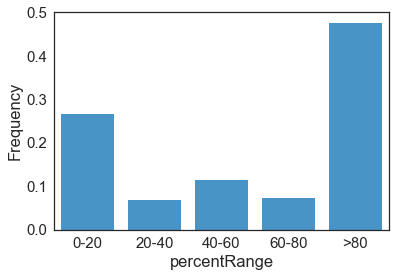

In [57]:
# Visualize the distribution
f, ax = plt.subplots()
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_style("white")
x = np.random.normal(size=100)
# ax = sns.barplot(x="percentRange", y="frequency", data=watch_count, palette="Greens_d")
ax = sns.barplot(x="percentRange", y="Frequency", data=watch_count, color='#3498db')



In [59]:
def savefig(figure, name):
    for fmt in ['pdf', 'eps']:
        fn = "../Graphs/{}.{}".format(name, fmt)
        figure.savefig(fn, format=fmt, dpi=300, bbox_inches='tight', pad_inches=0.1, frameon=True)
        print("saved figure {} as {}".format(figure, fn))

In [60]:
savefig(f, "Percent Watched 4.26 update")

saved figure Figure(432x288) as ../Graphs/Percent Watched 4.26 update.pdf
saved figure Figure(432x288) as ../Graphs/Percent Watched 4.26 update.eps


### Do people watch more than 50%?

In [35]:
watch_more_than_half = watch_noml_small[watch_noml_small['percentWatched'] >= 50]
watch_more_than_half.count()

userId              100676
loginId             100676
movieId             100676
youtubeTrailerId    100676
percentWatched      100676
positionInList      100676
tstamp              100676
dtype: int64

### Number of recommendations liked 

In [32]:
rec_play_liked = pd.read_csv('../Clean_Data/rec_played_liked.csv')
rec_play_liked.count()
# 291

Unnamed: 0          9210
userId              9210
loginId             9210
movieId             9210
youtubeTrailerId    8561
positionInList      9210
action              9210
tstamp              9210
recommenderId       9210
isLiked              291
dtype: int64

### Number of different actions (Trailer likes, wishlist movies)

In [61]:
# 2.23.2018 Update: removed grouplens researchers

# Connect to the database
import pymysql.cursors
import json
import re

# We will use these lists to generate a table later. 

sessionIds = []
loginIds = []

# Connect to the database
connection = pymysql.connect(host="127.0.0.1",
                             user="web",
                             password="atth1132",
                             db="ML3_mirror")

try:
    with connection.cursor() as cursor:
        # This query select rows from log_trailer_actions where the action is either TrailerModalLaunched or Recommendations Refreshed
        # These two actions indicate that a recommendation list is generated. 
        
        sql = """
        SELECT log_trailer_actions.userId, log_trailer_actions.loginId, log_trailer_actions.movieId, log_trailer_actions.action, log_trailer_actions.tstamp       
        FROM user_data
        RIGHT JOIN log_trailer_actions
        ON log_trailer_actions.userId = user_data.userId
        WHERE log_trailer_actions.tstamp < '2018-01-17 01:59:42' AND user_data.excludeFromExperiments='N'
        ORDER BY log_trailer_actions.loginId
        """
        cursor.execute(sql)
        result = cursor.fetchall()
            
finally: 
    connection.close()


In [62]:
trailer_actions = pd.DataFrame(list(result), columns=['userId','loginId','movieId','action','tstamp'])

In [66]:
trailer_actions_count = trailer_actions.groupby('action').count().reset_index()
trailer_actions_count

,action,userId,loginId,movieId,tstamp
0,GoToMovieDetails,989,989,989,989
1,IssueRaised,79,79,79,79
2,MovieDetailsModalClosed,6234,6234,6234,6234
3,MovieDetailsModalOpened,6745,6745,6745,6745
4,PlayedFromLaunch,176777,176777,176777,176777
5,PlayedFromNext,1459,1459,1459,1459
6,PlayedFromPrevious,197,197,197,197
7,PlayedFromRecommendation,8445,8445,8445,8445
8,PlayedFromYoutubePlayer,396421,396421,396421,396421
9,RatedMovie,1343,1343,1343,1343
